<a href="https://colab.research.google.com/github/TobyHerlong/Finance/blob/main/Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a **pairs trading strategy** between **TLT (20+ Year Treasury Bond ETF)** and **SHY (1-3 Year Treasury Bond ETF)**. The core idea is to identify temporary dislocations in the price relationship (spread) between these two highly correlated assets.

**Key Aspects:**

*   **Data Acquisition:** Downloads historical adjusted close prices for TLT and SHY using `yfinance`.
*   **Beta-Hedged Spread:** Calculates a dynamically hedged spread to account for varying correlation and volatility between the two assets.
*   **Z-Score:** Utilizes the Z-score of the spread to identify statistically significant deviations from its historical mean, signaling potential entry points.
*   **RSI (Relative Strength Index) Filter:** Incorporates RSI on TLT as an additional filter to confirm overbought/oversold conditions, aiming to improve trade quality.
*   **Volatility Targeting:** Adjusts position sizing based on the rolling volatility of the spread, aiming for a consistent level of risk exposure.
*   **Performance Metrics:** Calculates a comprehensive set of performance metrics including total return, annualized return, Sharpe ratio, maximum drawdown, win rate, and PnL.
*   **Visualization:** Generates plots for prices, Z-score with entry/exit levels, RSI with overbought/oversold levels, and cumulative PnL to visually assess strategy performance.

Error accessing 'Adj Close' columns with key ('Price', 'Adj Close', Ticker): 'Key length (3) exceeds index depth (2)'. Checking other potential keys.
Downloaded 3,773 observations using key ('Adj Close', Ticker) from 2010-01-04 to 2024-12-30



,TLT,SHY
Date,,
2010-01-04,56.763172,66.588554
2010-01-05,57.129780,66.668732
2010-01-06,56.365009,66.676758
2010-01-07,56.459820,66.660721
2010-01-08,56.434525,66.724808


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TLT     3773 non-null   float64
 1   SHY     3773 non-null   float64
dtypes: float64(2)
memory usage: 88.4 KB
After calculating features and dropping NaNs: 3,714 observations

After calculating volatility features and dropping NaNs: 3,462 observations



Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Position"].iloc[i] = current_position
/tmp/ipython-input-1281556160.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Position"].iloc[i] = current_position
/tmp/ipython-input-1281556160.py:192: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical ex

After generating signals: 3,462 observations

After applying volatility targeting: 3,462 observations

After calculating returns and PnL: 3,462 observations


PERFORMANCE SUMMARY: RSI-Filtered TLT/SHY Pairs Strategy (Volatility Targeted)
Backtest Period: 2011-03-29 → 2024-12-30
Obs (levels): 3,462
Backtest days: 5,025
Hit-rate window: 60d
Entry/Exit thresholds: Z Entry: ±2.0, Z Exit: ±0.5, RSI: 30/70
Trading Days (active): 1,414
Days in Position: 1,414 (40.8%)
Completed Trades: 27
Avg Trade Duration: 52.4 days

STRATEGY PARAMETERS:
  Z-Score Window: 60 days
  RSI Period: 14 days
  Beta Window: 252 days
  Entry Thresholds: Z < -2.0 & RSI < 30 | Z > 2.0 & RSI > 70
  Exit Threshold: |Z| < 0.5
  Target Volatility: 10%

STRATEGY PERFORMANCE:
  Total Return: 221.07%
  Average annual return: 8.85%
  Annualized Volatility: 12.47%
  Annualized Sharpe: 1.650
  Calmar Ratio: 0.152
  Win Rate: 55.6%
  Max Drawdown: -58.31%
  Final PnL: $1,209,905

BUY-AND-HOLD COMPARISON (TLT) over active strategy

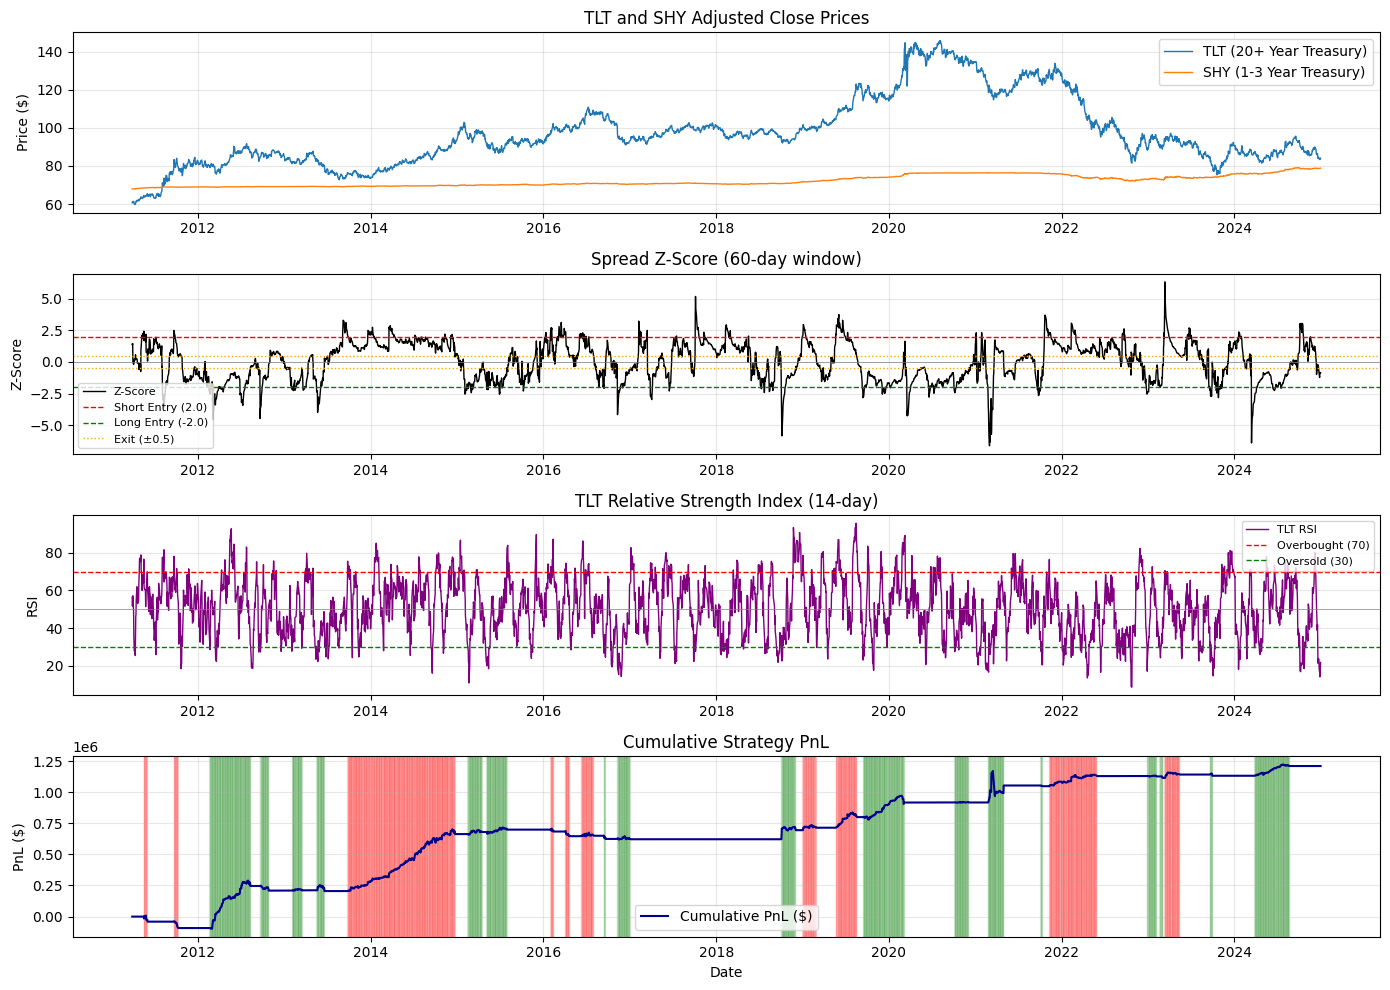

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# ----------------------- User Parameters -----------------------
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"
ZSCORE_WINDOW = 60  # Rolling window for spread mean/std
RSI_PERIOD = 14  # RSI calculation period
ZSCORE_ENTRY_LONG = -2.0  # Enter long spread when Z < -2.0
ZSCORE_ENTRY_SHORT = 2.0  # Enter short spread when Z > +2.0
ZSCORE_EXIT = 0.5  # Exit when |Z| < 0.5
RSI_OVERSOLD = 30  # RSI threshold for long entry
RSI_OVERBOUGHT = 70  # RSI threshold for short entry
BETA_WINDOW = 252  # Rolling window for beta calculation
NOTIONAL = 1_000_000.0  # Total capital
ANNUALIZATION = 252  # Trading days per year
TARGET_VOLATILITY = 0.10  # Target volatility for volatility targeting
RISK_FREE_RATE = 0.01  # Annual risk-free rate
MAX_POSITION_SCALER = 3.0  # Maximum volatility scaler cap

# ----------------------- Download Data -----------------------
print("Downloading data...")
# Fetch data with auto_adjust=False to ensure multi-level columns including 'Adj Close'
data = yf.download(["TLT", "SHY"], start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

df = pd.DataFrame() # Initialize df as empty DataFrame

# Process fetched data if not empty
if not data.empty:
    # Access the 'Adj Close' column correctly using multi-level indexing based on kernel state
    try:
        tlt_adj_close = data[("Price", "Adj Close", "TLT")]
        shy_adj_close = data[("Price", "Adj Close", "SHY")]
        # Create a new DataFrame with only the 'Adj Close' prices and simplified column names
        df = pd.DataFrame({"TLT": tlt_adj_close, "SHY": shy_adj_close}).dropna()

        print(f"Downloaded {len(df):,} observations from {df.index.min().date()} to {df.index.max().date()}\n")
        display(df.head())
        df.info()

    except KeyError as e:
        print(f"Error accessing 'Adj Close' columns with key ('Price', 'Adj Close', Ticker): {e}. Checking other potential keys.")
        # Fallback to try accessing with key ('Adj Close', Ticker) which was previously attempted
        try:
             tlt_adj_close = data[("Adj Close", "TLT")]
             shy_adj_close = data[("Adj Close", "SHY")]
             df = pd.DataFrame({"TLT": tlt_adj_close, "SHY": shy_adj_close}).dropna()
             print(f"Downloaded {len(df):,} observations using key ('Adj Close', Ticker) from {df.index.min().date()} to {df.index.max().date()}\n")
             display(df.head())
             df.info()
        except KeyError as e2:
             print(f"Error accessing 'Adj Close' columns with key ('Adj Close', Ticker) either: {e2}. Please check the exact data structure returned by yfinance.")
             df = pd.DataFrame() # Set df to empty if processing fails


# ----------------------- Calculate Beta-Hedged Spread -----------------------
# Add a check to ensure df is not empty before proceeding
if not df.empty:
    df["TLT_Returns"] = df["TLT"].pct_change()
    df["SHY_Returns"] = df["SHY"].pct_change()

    # Ensure BETA_WINDOW is defined (assuming it's in user parameters)
    try:
        BETA_WINDOW
    except NameError:
        print("BETA_WINDOW not defined. Using default 252.")
        BETA_WINDOW = 252

    rolling_cov = df["TLT_Returns"].rolling(BETA_WINDOW).cov(df["SHY_Returns"])
    rolling_var = df["SHY_Returns"].rolling(BETA_WINDOW).var()
    df["Beta"] = (rolling_cov / rolling_var).fillna(method="bfill")
    df["Spread"] = df["TLT"] - df["Beta"] * df["SHY"]

    # ----------------------- Calculate Z-Score -----------------------
    # Ensure ZSCORE_WINDOW is defined (assuming it's in user parameters)
    try:
        ZSCORE_WINDOW
    except NameError:
        print("ZSCORE_WINDOW not defined. Using default 60.")
        ZSCORE_WINDOW = 60

    df["Spread_Mean"] = df["Spread"].rolling(ZSCORE_WINDOW).mean()
    df["Spread_Std"] = df["Spread"].rolling(ZSCORE_WINDOW).std()
    df["ZScore"] = (df["Spread"] - df["Spread_Mean"]) / df["Spread_Std"]

    # ----------------------- Calculate RSI -----------------------
    def calculate_rsi(prices, period=14):
        """Calculate Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        epsilon = 1e-10
        # Handle division by zero for rs
        with np.errstate(divide='ignore', invalid='ignore'):
            rs = gain / (loss + epsilon)
        rsi = 100 - (100 / (1 + rs))
        return rsi

    # Ensure RSI_PERIOD is defined (assuming it's in user parameters)
    try:
        RSI_PERIOD
    except NameError:
        print("RSI_PERIOD not defined. Using default 14.")
        RSI_PERIOD = 14

    df["RSI"] = calculate_rsi(df["TLT"], RSI_PERIOD)
    df = df.dropna()
    print(f"After calculating features and dropping NaNs: {len(df):,} observations\n")

    # ----------------------- Calculate Volatility Targeting -----------------------
    # Add a check for 'TLT' and 'Spread' columns before using them
    if 'TLT' not in df.columns or 'Spread' not in df.columns:
         print("Error: Necessary columns missing before volatility calculation.")
         df['TLT_Daily_Change'] = np.nan
         df['Spread_Daily_Change'] = np.nan
         df['rolling_spread_vol'] = np.nan
         df['Vol_Scaler'] = 0.0
    else:
        df['TLT_Daily_Change'] = df['TLT'].pct_change()
        df['Spread_Daily_Change'] = df['Spread'].pct_change()

        # Ensure ANNUALIZATION is defined (assuming it's in user parameters)
        try:
            ANNUALIZATION
        except NameError:
            print("ANNUALIZATION not defined. Using default 252.")
            ANNUALIZATION = 252

        df['rolling_spread_vol'] = df['Spread_Daily_Change'].rolling(BETA_WINDOW).std() * np.sqrt(ANNUALIZATION)

        epsilon = 1e-9
        # Ensure TARGET_VOLATILITY and MAX_POSITION_SCALER are defined (assuming they are in user parameters)
        try:
            TARGET_VOLATILITY
            MAX_POSITION_SCALER
        except NameError:
            print("TARGET_VOLATILITY or MAX_POSITION_SCALER not defined. Using defaults.")
            TARGET_VOLATILITY = 0.10
            MAX_POSITION_SCALER = 3.0

        df['Vol_Scaler'] = TARGET_VOLATILITY / (df['rolling_spread_vol'] + epsilon)
        df['Vol_Scaler'] = df['Vol_Scaler'].clip(upper=MAX_POSITION_SCALER, lower=0.0)

    df = df.dropna()
    print(f"After calculating volatility features and dropping NaNs: {len(df):,} observations\n")

    # ----------------------- Generate Trading Signals -----------------------
    # Add a check for necessary columns before generating signals
    if 'ZScore' not in df.columns or 'RSI' not in df.columns or 'Vol_Scaler' not in df.columns:
        print("Error: Necessary columns missing before generating signals. Skipping signal generation.")
        df["Position"] = 0
        df["FinalScaledPosition"] = 0.0
    else:
        df["Position"] = 0
        current_position = 0

        # Ensure ZSCORE_ENTRY_LONG, ZSCORE_ENTRY_SHORT, ZSCORE_EXIT, RSI_OVERSOLD, RSI_OVERBOUGHT are defined
        try:
            ZSCORE_ENTRY_LONG
            ZSCORE_ENTRY_SHORT
            ZSCORE_EXIT
            RSI_OVERSOLD
            RSI_OVERBOUGHT
        except NameError:
            print("Entry/Exit parameters not defined. Using defaults.")
            ZSCORE_ENTRY_LONG = -2.0
            ZSCORE_ENTRY_SHORT = 2.0
            ZSCORE_EXIT = 0.5
            RSI_OVERSOLD = 30
            RSI_OVERBOUGHT = 70

        for i in range(len(df)):
            z = df["ZScore"].iloc[i]
            rsi = df["RSI"].iloc[i]

            # Check exit condition (mean reversion)
            if current_position != 0 and abs(z) < ZSCORE_EXIT:
                current_position = 0

            # Check entry conditions (only when flat)
            elif current_position == 0:
                # Long spread: Z < -2.0 AND RSI < 30
                if z < ZSCORE_ENTRY_LONG and rsi < RSI_OVERSOLD:
                    current_position = 1
                # Short spread: Z > +2.0 AND RSI > 70
                elif z > ZSCORE_ENTRY_SHORT and rsi > RSI_OVERBOUGHT:
                    current_position = -1

            df["Position"].iloc[i] = current_position

        df = df.dropna(subset=["Position"])
        print(f"After generating signals: {len(df):,} observations\n")

        # ----------------------- Apply Volatility Targeting -----------------------
        # Ensure NOTIONAL is defined (assuming it's in user parameters)
        try:
            NOTIONAL
        except NameError:
            print("NOTIONAL not defined. Using default 1_000_000.0.")
            NOTIONAL = 1_000_000.0

        df["FinalScaledPosition"] = df["Position"] * df["Vol_Scaler"]
        df["FinalDollarPosition"] = df["FinalScaledPosition"] * NOTIONAL
        print(f"After applying volatility targeting: {len(df):,} observations\n")


    # ----------------------- Calculate Returns and PnL -----------------------
    # Add checks for necessary columns before calculating returns/PnL
    if 'Spread' not in df.columns or 'FinalScaledPosition' not in df.columns or 'FinalDollarPosition' not in df.columns:
        print("Error: Necessary columns missing before calculating returns and PnL. Skipping PnL calculation.")
        df["SpreadReturn"] = 0.0
        df["StrategyReturn"] = 0.0
        df["Spread_Change"] = 0.0
        df["DailyPnL"] = 0.0
        df["CumPnL"] = 0.0
        df["CumReturn"] = 0.0
    else:
        df["SpreadReturn"] = df["Spread"].pct_change()
        df["StrategyReturn"] = df["FinalScaledPosition"].shift(1) * df["SpreadReturn"]

        df['Spread_Change'] = df['Spread'].diff()
        # Ensure Spread.shift(1) is not zero to avoid division by zero
        epsilon = 1e-9 # Ensure epsilon is defined
        denominator = df['Spread'].shift(1)
        df["DailyPnL"] = df["FinalDollarPosition"].shift(1) * (df['Spread_Change'] / (denominator + epsilon))
        df['DailyPnL'] = df['DailyPnL'].fillna(0)
        df["CumPnL"] = df["DailyPnL"].cumsum()
        df["CumReturn"] = (1 + df["StrategyReturn"].fillna(0)).cumprod() - 1

    print(f"After calculating returns and PnL: {len(df):,} observations\n")

    # ----------------------- Calculate Performance Metrics -----------------------
    # Add checks for necessary columns before calculating metrics
    if 'Position' not in df.columns or 'StrategyReturn' not in df.columns or 'CumReturn' not in df.columns or 'CumPnL' not in df.columns:
         print("Error: Necessary columns missing before calculating performance metrics. Skipping metrics calculation.")
         total_return = 0
         annualized_return = 0
         sharpe_ratio = 0
         win_rate = 0
         max_drawdown = 0
         calmar_ratio = 0
         days_in_position = 0
         num_trades = 0
         avg_trade_duration = 0
         volatility = 0
         bh_total_return = 0
         bh_annual_return = 0
         bh_volatility = 0
         bh_sharpe = 0
    else:
        # Filter strategy returns for metrics only during active trading periods
        strategy_returns_for_metrics = df[df['Position'].shift(1) != 0]['StrategyReturn'].dropna()

        # Total and annualized return
        total_return = df["CumReturn"].iloc[-1]
        total_days = (df.index.max() - df.index.min()).days
        years = total_days / 365.25

        if 1 + total_return <= 0 or years <= 0:
            annualized_return = -1 if total_return <= -1 else 0
        else:
            annualized_return = (1 + total_return) ** (1 / years) - 1

        # Sharpe ratio
        # Ensure RISK_FREE_RATE and ANNUALIZATION are defined
        try:
            RISK_FREE_RATE
            ANNUALIZATION
        except NameError:
             print("RISK_FREE_RATE or ANNUALIZATION not defined. Using defaults.")
             RISK_FREE_RATE = 0.01
             ANNUALIZATION = 252

        RISK_FREE_RATE_DAILY = (1 + RISK_FREE_RATE)**(1/ANNUALIZATION) - 1
        excess_returns = strategy_returns_for_metrics - RISK_FREE_RATE_DAILY
        mean_return = excess_returns.mean()
        std_return = excess_returns.std()
        sharpe_ratio = (np.sqrt(ANNUALIZATION) * mean_return) / std_return if std_return > 0 else 0

        # Win rate calculation
        df["PositionChange"] = df["Position"].diff()
        trade_outcomes = []
        in_trade = False
        entry_date = None
        entry_cum_pnl = None

        # Ensure CumPnL column exists before iterating
        if 'CumPnL' in df.columns:
            for i in range(1, len(df)):
                if df['PositionChange'].iloc[i] != 0 and not in_trade:
                    if df['Position'].iloc[i] != 0:
                        entry_date = df.index[i]
                        # Use .loc to avoid SettingWithCopyWarning if df is a slice
                        entry_cum_pnl = df.loc[df.index[i-1], 'CumPnL'] if i > 0 and df.index[i-1] in df.index else 0 # Handle case i=0 and ensure index exists
                        in_trade = True
                elif df['PositionChange'].iloc[i] != 0 and in_trade:
                    if df['Position'].iloc[i] == 0:
                        exit_date = df.index[i]
                        # Use .loc to avoid SettingWithCopyWarning
                        exit_cum_pnl = df.loc[df.index[i], 'CumPnL'] if df.index[i] in df.index else df['CumPnL'].iloc[i-1] # Handle case where exit index might be out of bounds
                        trade_pnl = exit_cum_pnl - entry_cum_pnl
                        trade_outcomes.append(trade_pnl)
                        in_trade = False
                        entry_date = None
                        entry_cum_pnl = None

        winning_trades = sum(1 for outcome in trade_outcomes if outcome > 0)
        losing_trades = sum(1 for outcome in trade_outcomes if outcome < 0)
        num_trades = winning_trades + losing_trades
        win_rate = winning_trades / num_trades if num_trades > 0 else 0

        # Other metrics
        max_drawdown = (df["CumReturn"] - df["CumReturn"].cummax()).min()
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        days_in_position = (df["Position"] != 0).sum()
        avg_trade_duration = days_in_position / num_trades if num_trades > 0 else 0
        volatility = strategy_returns_for_metrics.std() * np.sqrt(ANNUALIZATION) if not strategy_returns_for_metrics.empty else 0


        # Buy and hold comparison
        # Add a check for TLT column and ensure strategy_returns_for_metrics is not empty for valid date range
        if 'TLT' in df.columns and not strategy_returns_for_metrics.empty:
            bh_start_date = strategy_returns_for_metrics.index.min()
            bh_end_date = strategy_returns_for_metrics.index.max()
            bh_tlt_prices_subset = df['TLT'].loc[bh_start_date:bh_end_date]

            if len(bh_tlt_prices_subset) > 1:
                bh_total_return = (bh_tlt_prices_subset.iloc[-1] / bh_tlt_prices_subset.iloc[0]) - 1
                bh_period_days = (bh_tlt_prices_subset.index.max() - bh_tlt_prices_subset.index.min()).days
                bh_years = bh_period_days / 365.25
                if bh_years > 0 and (1 + bh_total_return) > 0:
                    bh_annual_return = (1 + bh_total_return) ** (1 / bh_years) - 1
                else:
                    bh_annual_return = 0
                bh_tlt_returns_subset = bh_tlt_prices_subset.pct_change().dropna()
                bh_volatility = bh_tlt_returns_subset.std() * np.sqrt(ANNUALIZATION) if not bh_tlt_returns_subset.empty else 0
                bh_sharpe = (bh_tlt_returns_subset.mean() / bh_tlt_returns_subset.std()) * np.sqrt(ANNUALIZATION) if bh_tlt_returns_subset.std() > 0 else 0
            else:
                bh_total_return = 0
                bh_annual_return = 0
                bh_volatility = 0
                bh_sharpe = 0
        else:
             print("Warning: 'TLT' column not found or strategy returns period is empty for Buy and Hold comparison.")
             bh_total_return = 0
             bh_annual_return = 0
             bh_volatility = 0
             bh_sharpe = 0

    # ----------------------- Print Results -----------------------
    print("\n" + "=" * 80)
    print("PERFORMANCE SUMMARY: RSI-Filtered TLT/SHY Pairs Strategy (Volatility Targeted)")
    print("=" * 80)
    # Add checks before accessing df properties
    if not df.empty:
        print(f"Backtest Period: {df.index.min().date()} → {df.index.max().date()}")
        print(f"Obs (levels): {len(df):,}")
        # Ensure total_days is defined
        try:
            total_days
        except NameError:
            total_days = 0
            print("Warning: total_days not defined. Set to 0.")

        print(f"Backtest days: {total_days:,}")
    else:
        print("Backtest Period: Data not loaded")
        print("Obs (levels): 0")
        print("Backtest days: 0")

    # Ensure ZSCORE_WINDOW, ZSCORE_ENTRY_SHORT, ZSCORE_EXIT, RSI_OVERSOLD, RSI_OVERBOUGHT are defined
    try:
        ZSCORE_WINDOW
        ZSCORE_ENTRY_SHORT
        ZSCORE_EXIT
        RSI_OVERSOLD
        RSI_OVERBOUGHT
    except NameError:
        print("Strategy parameters for printing not defined. Using placeholders.")
        ZSCORE_WINDOW = 60
        ZSCORE_ENTRY_SHORT = 2.0
        ZSCORE_EXIT = 0.5
        RSI_OVERSOLD = 30
        RSI_OVERBOUGHT = 70


    print(f"Hit-rate window: {ZSCORE_WINDOW}d")
    print(f"Entry/Exit thresholds: Z Entry: ±{ZSCORE_ENTRY_SHORT}, Z Exit: ±{ZSCORE_EXIT}, RSI: {RSI_OVERSOLD}/{RSI_OVERBOUGHT}")
    # Ensure strategy_returns_for_metrics and days_in_position and num_trades and avg_trade_duration are defined
    try:
        len(strategy_returns_for_metrics)
        days_in_position
        num_trades
        avg_trade_duration
    except NameError:
         strategy_returns_for_metrics = []
         days_in_position = 0
         num_trades = 0
         avg_trade_duration = 0
         print("Warning: Metrics data not fully calculated. Some print values may be 0 or empty.")

    print(f"Trading Days (active): {len(strategy_returns_for_metrics):,}")
    print(f"Days in Position: {days_in_position:,} ({days_in_position/len(df)*100:.1f}%)" if not df.empty and len(df)>0 else "Days in Position: 0 (0.0%)")
    print(f"Completed Trades: {num_trades}")
    print(f"Avg Trade Duration: {avg_trade_duration:.1f} days")

    # Ensure strategy parameters for printing are defined
    try:
        ZSCORE_WINDOW
        RSI_PERIOD
        BETA_WINDOW
        ZSCORE_ENTRY_LONG
        ZSCORE_ENTRY_SHORT
        RSI_OVERSOLD
        RSI_OVERBOUGHT
        ZSCORE_EXIT
        TARGET_VOLATILITY
    except NameError:
        print("Warning: Strategy parameters not fully defined for printing.")
        ZSCORE_WINDOW = 60
        RSI_PERIOD = 14
        BETA_WINDOW = 252
        ZSCORE_ENTRY_LONG = -2.0
        ZSCORE_ENTRY_SHORT = 2.0
        RSI_OVERSOLD = 30
        RSI_OVERBOUGHT = 70
        ZSCORE_EXIT = 0.5
        TARGET_VOLATILITY = 0.10

    print(f"\nSTRATEGY PARAMETERS:")
    print(f"  Z-Score Window: {ZSCORE_WINDOW} days")
    print(f"  RSI Period: {RSI_PERIOD} days")
    print(f"  Beta Window: {BETA_WINDOW} days")
    print(f"  Entry Thresholds: Z < {ZSCORE_ENTRY_LONG} & RSI < {RSI_OVERSOLD} | Z > {ZSCORE_ENTRY_SHORT} & RSI > {RSI_OVERBOUGHT}")
    print(f"  Exit Threshold: |Z| < {ZSCORE_EXIT}")
    print(f"  Target Volatility: {TARGET_VOLATILITY*100:.0f}%")

    # Ensure performance metrics for printing are defined
    try:
        total_return
        annualized_return
        volatility
        sharpe_ratio
        calmar_ratio
        win_rate
        max_drawdown
    except NameError:
        print("Warning: Performance metrics not fully calculated for printing.")
        total_return = 0
        annualized_return = 0
        volatility = 0
        sharpe_ratio = 0
        calmar_ratio = 0
        win_rate = 0
        max_drawdown = 0

    print(f"\nSTRATEGY PERFORMANCE:")
    print(f"  Total Return: {total_return*100:,.2f}%")
    print(f"  Average annual return: {annualized_return*100:.2f}%")
    print(f"  Annualized Volatility: {volatility*100:.2f}%")
    print(f"  Annualized Sharpe: {sharpe_ratio:.3f}")
    print(f"  Calmar Ratio: {calmar_ratio:.3f}")
    print(f"  Win Rate: {win_rate*100:.1f}%")
    print(f"  Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"  Final PnL: ${df['CumPnL'].iloc[-1]:,.0f}" if 'CumPnL' in df.columns and not df.empty else "Final PnL: $0")

    # Ensure buy and hold metrics for printing are defined
    try:
        bh_total_return
        bh_annual_return
        bh_volatility
        bh_sharpe
    except NameError:
         print("Warning: Buy-and-Hold metrics not fully calculated for printing.")
         bh_total_return = 0
         bh_annual_return = 0
         bh_volatility = 0
         bh_sharpe = 0


    print(f"\nBUY-AND-HOLD COMPARISON (TLT) over active strategy period:")
    print(f"  Total Return: {bh_total_return*100:,.2f}%")
    print(f"  Annualized Return: {bh_annual_return*100:.2f}%")
    print(f"  Annualized Volatility: {bh_volatility*100:.2f}%")
    print(f"  Annualized Sharpe: {bh_sharpe:.3f}")

    print(f"\nSTRATEGY vs BUY-AND-HOLD:")
    print(f"  Excess Return (Ann.): {(annualized_return - bh_annual_return)*100:.2f}%" if 'annualized_return' in locals() and 'bh_annual_return' in locals() else "N/A")
    print(f"  Sharpe Improvement: {sharpe_ratio - bh_sharpe:.3f}" if 'sharpe_ratio' in locals() and 'bh_sharpe' in locals() else "N/A")
    print("=" * 80)

    # ----------------------- Visualizations -----------------------
    # Add a check to ensure df is not empty before plotting
    if not df.empty:
        fig = plt.figure(figsize=(14, 10))

        # Plot 1: TLT and SHY Prices
        ax1 = plt.subplot(4, 1, 1)
        # Add checks for TLT and SHY columns before plotting
        if 'TLT' in df.columns and 'SHY' in df.columns:
             ax1.plot(df.index, df["TLT"], label="TLT (20+ Year Treasury)", linewidth=1)
             ax1.plot(df.index, df["SHY"], label="SHY (1-3 Year Treasury)", linewidth=1)
             ax1.set_ylabel("Price ($)")
             ax1.set_title("TLT and SHY Adjusted Close Prices")
             ax1.legend(loc="best")
             ax1.grid(alpha=0.3)
        else:
             ax1.set_title("TLT and SHY Prices (Data not available)")
             ax1.text(0.5, 0.5, "Data not available for plotting", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


        # Plot 2: Z-Score with Entry/Exit Levels
        ax2 = plt.subplot(4, 1, 2)
        # Add check for ZScore column
        if 'ZScore' in df.columns:
            # Ensure ZSCORE_ENTRY_SHORT, ZSCORE_ENTRY_LONG, ZSCORE_EXIT are defined for plotting labels
            try:
                ZSCORE_ENTRY_SHORT
                ZSCORE_ENTRY_LONG
                ZSCORE_EXIT
            except NameError:
                 print("Entry/Exit parameters for plotting labels not defined. Using defaults.")
                 ZSCORE_ENTRY_SHORT = 2.0
                 ZSCORE_ENTRY_LONG = -2.0
                 ZSCORE_EXIT = 0.5

            ax2.plot(df.index, df["ZScore"], label="Z-Score", linewidth=1, color="black")
            ax2.axhline(ZSCORE_ENTRY_SHORT, color="red", linestyle="--", linewidth=1, label=f"Short Entry ({ZSCORE_ENTRY_SHORT})")
            ax2.axhline(ZSCORE_ENTRY_LONG, color="green", linestyle="--", linewidth=1, label=f"Long Entry ({ZSCORE_ENTRY_LONG})")
            ax2.axhline(ZSCORE_EXIT, color="orange", linestyle=":", linewidth=1, label=f"Exit (±{ZSCORE_EXIT})")
            ax2.axhline(-ZSCORE_EXIT, color="orange", linestyle=":", linewidth=1)
            ax2.axhline(0, color="gray", linestyle="-", linewidth=0.5)
            ax2.set_ylabel("Z-Score")
            # Ensure ZSCORE_WINDOW is defined for plotting title
            try:
                ZSCORE_WINDOW
            except NameError:
                 print("ZSCORE_WINDOW for plotting title not defined. Using default 60.")
                 ZSCORE_WINDOW = 60

            ax2.set_title(f"Spread Z-Score ({ZSCORE_WINDOW}-day window)")
            ax2.legend(loc="best", fontsize=8)
            ax2.grid(alpha=0.3)
        else:
            ax2.set_title("Spread Z-Score (Data not available)")
            ax2.text(0.5, 0.5, "Z-Score data not available for plotting", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)


        # Plot 3: RSI with Overbought/Oversold Levels
        ax3 = plt.subplot(4, 1, 3)
        # Add check for RSI column
        if 'RSI' in df.columns:
            # Ensure RSI_OVERBOUGHT and RSI_OVERSOLD and RSI_PERIOD are defined for plotting labels and title
            try:
                RSI_OVERBOUGHT
                RSI_OVERSOLD
                RSI_PERIOD
            except NameError:
                 print("RSI parameters for plotting not defined. Using defaults.")
                 RSI_OVERBOUGHT = 70
                 RSI_OVERSOLD = 30
                 RSI_PERIOD = 14

            ax3.plot(df.index, df["RSI"], label="TLT RSI", linewidth=1, color="purple")
            ax3.axhline(RSI_OVERBOUGHT, color="red", linestyle="--", linewidth=1, label=f"Overbought ({RSI_OVERBOUGHT})")
            ax3.axhline(RSI_OVERSOLD, color="green", linestyle="--", linewidth=1, label=f"Oversold ({RSI_OVERSOLD})")
            ax3.axhline(50, color="gray", linestyle="-", linewidth=0.5)
            ax3.set_ylabel("RSI")
            ax3.set_title(f"TLT Relative Strength Index ({RSI_PERIOD}-day)")
            ax3.legend(loc="best", fontsize=8)
            ax3.grid(alpha=0.3)
        else:
            ax3.set_title("TLT Relative Strength Index (Data not available)")
            ax3.text(0.5, 0.5, "RSI data not available for plotting", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)


        # Plot 4: Cumulative PnL
        ax4 = plt.subplot(4, 1, 4)
        # Add check for CumPnL column
        if 'CumPnL' in df.columns:
            ax4.plot(df.index, df["CumPnL"], label="Cumulative PnL ($)", linewidth=1.5, color="darkblue")
            ax4.set_ylabel("PnL ($)")
            ax4.set_xlabel("Date")
            ax4.set_title("Cumulative Strategy PnL")
            ax4.legend(loc="best")
            ax4.grid(alpha=0.3)

            # Add position shading (only if Position column exists and df is not empty)
            if 'Position' in df.columns and not df.empty:
                for i in range(1, len(df)):
                    if df["Position"].iloc[i] == 1:  # Long spread
                        ax4.axvspan(df.index[i-1], df.index[i], alpha=0.1, color="green")
                    elif df["Position"].iloc[i] == -1:  # Short spread
                        ax4.axvspan(df.index[i-1], df.index[i], alpha=0.1, color="red")
        else:
            ax4.set_title("Cumulative Strategy PnL (Data not available)")
            ax4.text(0.5, 0.5, "Cumulative PnL data not available for plotting", horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes)


        plt.tight_layout()
        plt.show()
    else:
        print("\nSkipping visualizations as DataFrame df is empty.")

else:
    print("\nSkipping performance metrics and visualizations as DataFrame df is empty.")